# High Dimensional Weighted Gene Correlation Network Analysis (hdWGCNA)

**Authorship:**
Adam Klie, *08/24/2022*
***
**Description:**
Notebook to run a WGCNA on stimulated pancreatic islet multiome data (well just the RNA)
***

# Set-up

In [1]:
# Conversion libraries and Seurat
library(SeuratDisk)
library(SeuratData)
library(Seurat)
library(Signac)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::reduce() masks Signac::reduce()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [2]:
# Parameters
CELL.TYPES <- "beta"  # Meaning α, β, δ in this context
ASSAY <- "RNA"
NORMALIZATION <- "ND"
NN <- 25
GENES <- "all"

In [3]:
# File names for saving
NAME=paste0(CELL.TYPES, "cells_", GENES, "genes_", NORMALIZATION, "_", NN, "neighbors")
OUT= file.path("./network_construction", NAME)
OUT

[1] "./network_construction/betacells_allgenes_ND_25neighbors"

# Data Loading

In [4]:
# Load processed Seurat object
RDS_FILE = "/cellar/users/aklie/data/beta_cell_networks/multiomic_stimulated_sc/14sep22_DM023_palmitate_endocrine.rds"

In [5]:
# Load in the seurat object from the cleaned version
adata <- readRDS(RDS_FILE)

In [6]:
# Check it!
adata

An object of class Seurat 
696827 features across 16342 samples within 6 assays 
Active assay: SCT (28796 features, 3000 variable features)
 5 other assays present: RNA, RNA_raw, ATAC, mpeak, peaks
 9 dimensional reductions calculated: lsi, harmony.atac, pca, harmony.sct, umap.wnn, umap.atac, umap.sct, harmony.peaks, umap.peaks

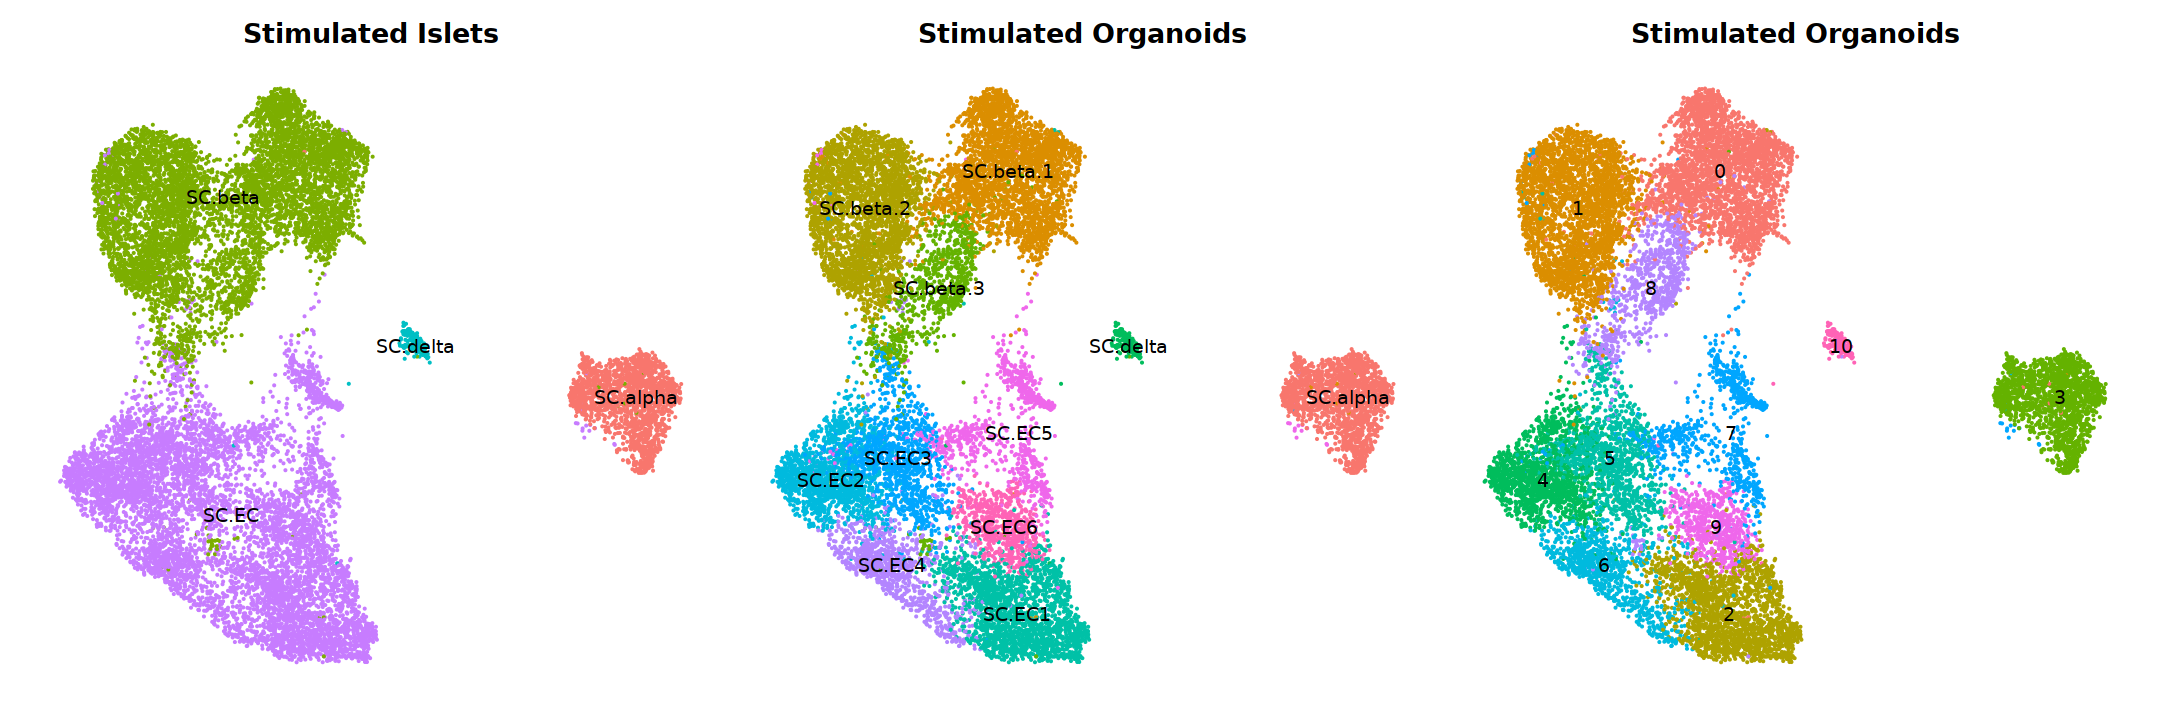

In [7]:
# Double check the umaps for clustering
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata, group.by='cell.type.1', reduction="umap.wnn", label=TRUE) +
   umap_theme() + ggtitle('Stimulated Organoids') + NoLegend()
p2 <- DimPlot(adata, reduction="umap.wnn", group.by='cell.type.2', label=TRUE) +
   umap_theme() + ggtitle('Stimulated Organoids') + NoLegend()
p3 <- DimPlot(adata, reduction="umap.wnn", group.by='seurat_clusters', label=TRUE) +
   umap_theme() + ggtitle('Stimulated Organoids') + NoLegend()
p1 + p2 + p3

# Set up Seurat object for WGCNA
 - This uses the counts slot of the assay to perform fraction based selection: https://github.com/smorabit/hdWGCNA/blob/9ed9084d30891075e69a0d482dd664bcf0e33463/R/WGCNA_functions.R

In [8]:
# Grab only α, β and δ cells
if (CELL.TYPES == "all") {
    TARGET_CELLS = 1000
    seurat_obj <- adata
} else if (CELL.TYPES == "beta") {
    seurat_obj <- subset(adata, subset = cell.type.1 %in% c("SC.beta"))
    TARGET_CELLS = 10000
} else if (CELL.TYPES == "alpha") {
    seurat_obj <- subset(adata, subset = cell.type.1 %in% c("SC.alpha"))
    TARGET_CELLS = 100000
} else if (CELL.TYPES == "delta") {
    seurat_obj <- subset(adata, subset = cell.type.1 %in% c("SC.delta"))
    TARGET_CELLS = 100000
} else if (CELL.TYPES == "endocrine") {
    seurat_obj <- subset(adata, subset = cell.type.1 %in% c("SC.EC"))
    TARGET_CELLS = 100000
}

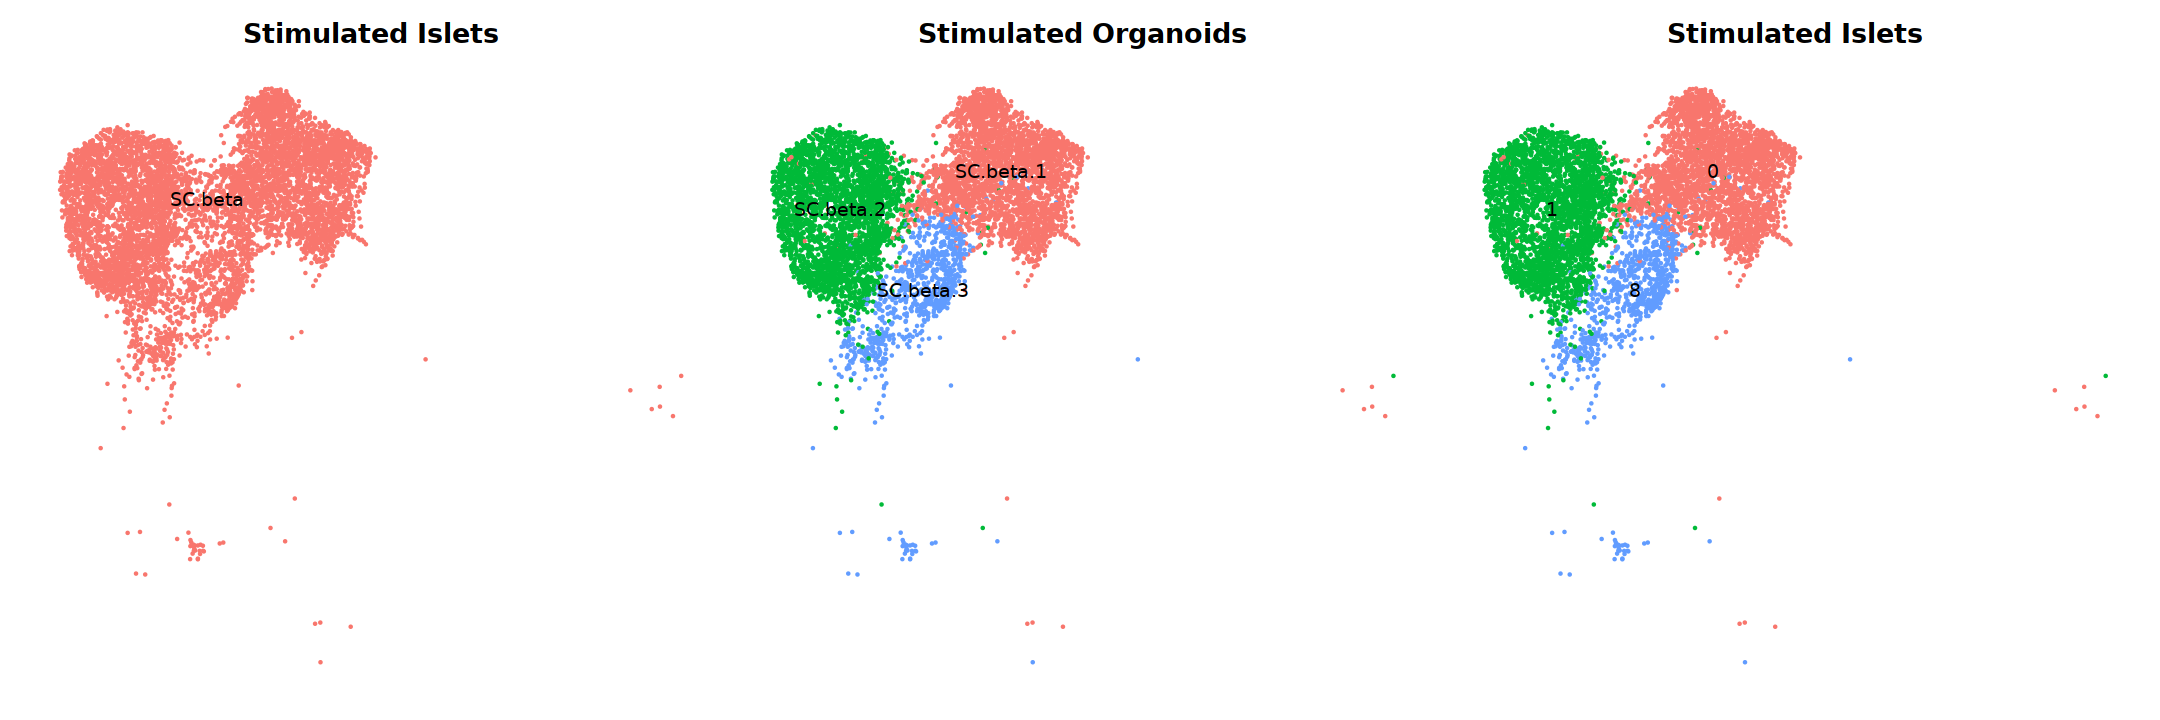

In [9]:
# Double check the umaps for clustering
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(seurat_obj, group.by='cell.type.1', reduction="umap.wnn", label=TRUE) +
   umap_theme() + ggtitle('Stimulated Organoids') + NoLegend()
p2 <- DimPlot(seurat_obj, reduction="umap.wnn", group.by='cell.type.2', label=TRUE) +
   umap_theme() + ggtitle('Stimulated Organoids') + NoLegend()
p3 <- DimPlot(seurat_obj, reduction="umap.wnn", group.by='seurat_clusters', label=TRUE) +
   umap_theme() + ggtitle('Stimulated Islets') + NoLegend()
p1 + p2 + p3

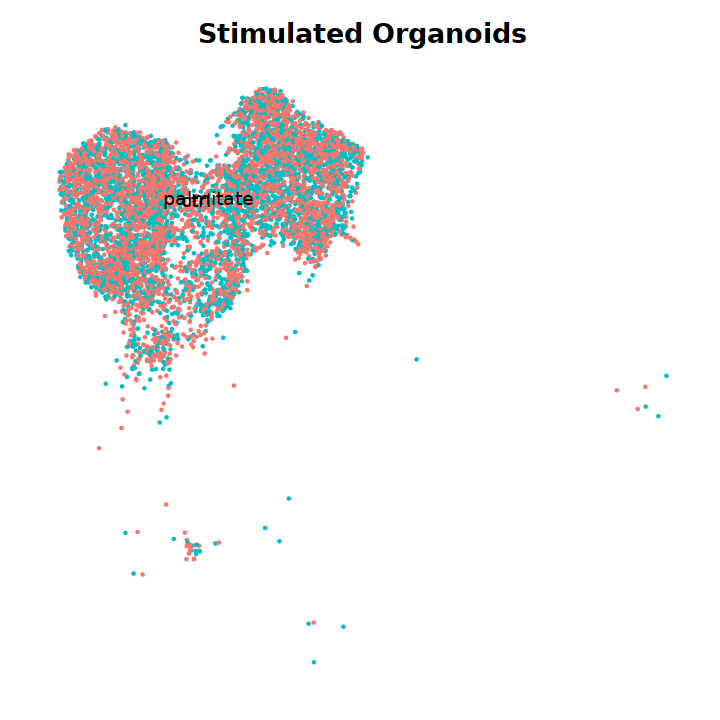

In [11]:
options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seurat_obj, reduction="umap.wnn", group.by='condition', label=TRUE) +
   umap_theme() + ggtitle('Stimulated Organoids') + NoLegend()

In [14]:
# Double check the cell type numbers that are left
table(seurat_obj$cell.type.1)


SC.beta 
   7042 

In [56]:
# Double check the cell type numbers that are left
table(seurat_obj$cell.type.2)


SC.beta.1 SC.beta.2 SC.beta.3 
     3124      3080       838 

Picking joint bandwidth of 0.197



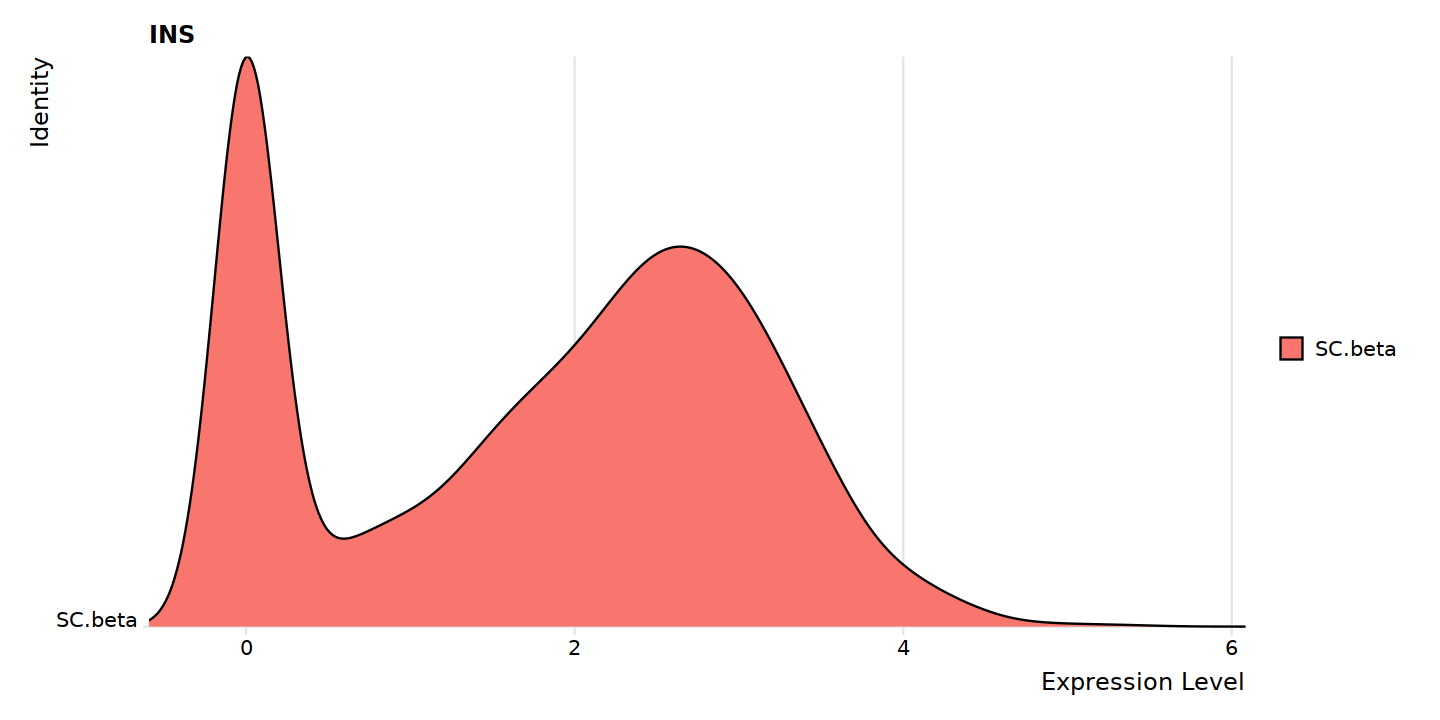

In [15]:
# Set-up the object for either the ND or SCT based worklow
if (ASSAY == "RNA") {
    DefaultAssay(seurat_obj) <- "RNA"
    seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)
    plot <- RidgePlot(seurat_obj, features = "INS", assay="RNA", slot="data", group.by = "cell.type.1", ncol=1)
    if (GENES == "variable") {
        seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
        print(head(VariableFeatures(seurat_obj)))
    }
} else if (ASSAY == "SCT") {
    print("TODO")
}
plot

In [16]:
# Set-up a Seurat object for WGCNA
if (GENES == "all") {
    seurat_obj <- SetupForWGCNA(
        seurat_obj,
        gene_select = "fraction", # the gene selection approach
        fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
        wgcna_name = NAME # the name of the hdWGCNA experiment
    )
} else if (GENES == "variable") {
    seurat_obj <- SetupForWGCNA(
        seurat_obj,
        gene_select = "variable", # the gene selection approach
        wgcna_name = NAME # the name of the hdWGCNA experiment
    )
}

In [17]:
# Check how many genes we end up using
length(get(NAME, seurat_obj@misc)$wgcna_genes)

[1] 11003

# Construct metacells
 - Do we care about the slot with which metacells are constructed here?
     - By default the "counts" slot of the active assay is used
 - Why do we normalize metacells here?
 - Adds a metacell_grouping column to the metadata

In [18]:
# construct metacells n each group
seurat_obj <- MetacellsByGroups(
  seurat_obj = seurat_obj,
  group.by = c("cell.type.1"), # specify the columns in adata@meta.data to group by
  k = NN, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'cell.type.1', # set the Idents of the metacell seurat object
  assay=ASSAY,
  slot="counts",
  target_metacells = TARGET_CELLS,
)

[1] "done making metacells"
[1] 1
[1] "metacell shape"


In [19]:
# Check what is now available in the misc attribute
names(get(NAME, seurat_obj@misc))

[1] "wgcna_group"        "wgcna_genes"        "wgcna_metacell_obj"
[4] "wgcna_params"

In [20]:
# See how many metacells there are
get(NAME, seurat_obj@misc)$wgcna_metacell_obj

An object of class Seurat 
36601 features across 2580 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [21]:
# TODO: Find out how many metacells of each type I have
table(get(NAME, seurat_obj@misc)$wgcna_metacell_obj$cell.type.1)


SC.beta 
   2580 

In [22]:
# Check the wgcna params
get(NAME, seurat_obj@misc)$wgcna_params

,name,max_shared,mean_shared,median_shared,density,n,cell.type.1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,SC.beta,10,0.1335837,0,0.358972,2580,SC.beta


In [23]:
# normalize metacell expression matrix (still don't know why we do this)
seurat_obj <- NormalizeMetacells(seurat_obj)

Picking joint bandwidth of 0.737



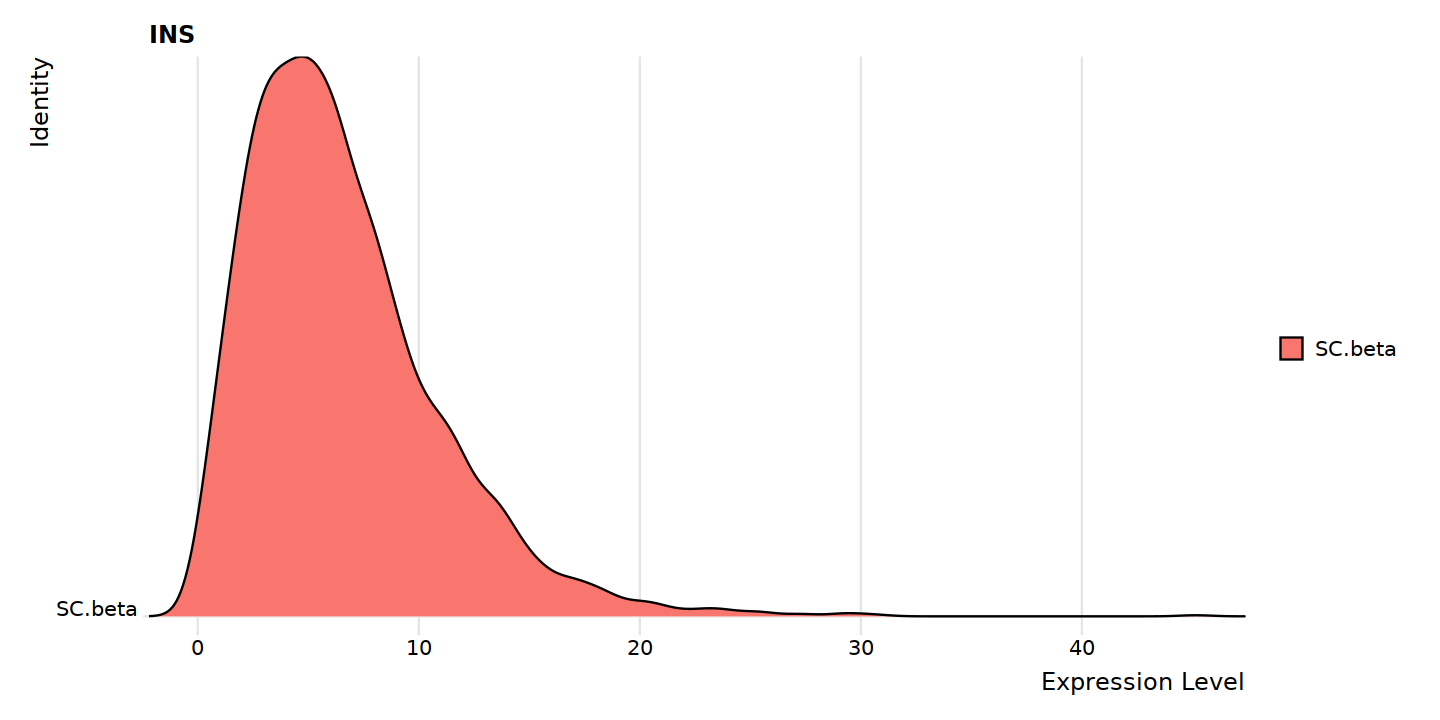

In [24]:
# Do a quick check to see the slots for the metacell object for counts slot (should look better than bulk but still counts)
RidgePlot(get(NAME, seurat_obj@misc)$wgcna_metacell_obj, features = "INS", assay="RNA", slot="counts", group.by = "cell.type.1", ncol=1)

Picking joint bandwidth of 2.25e-06



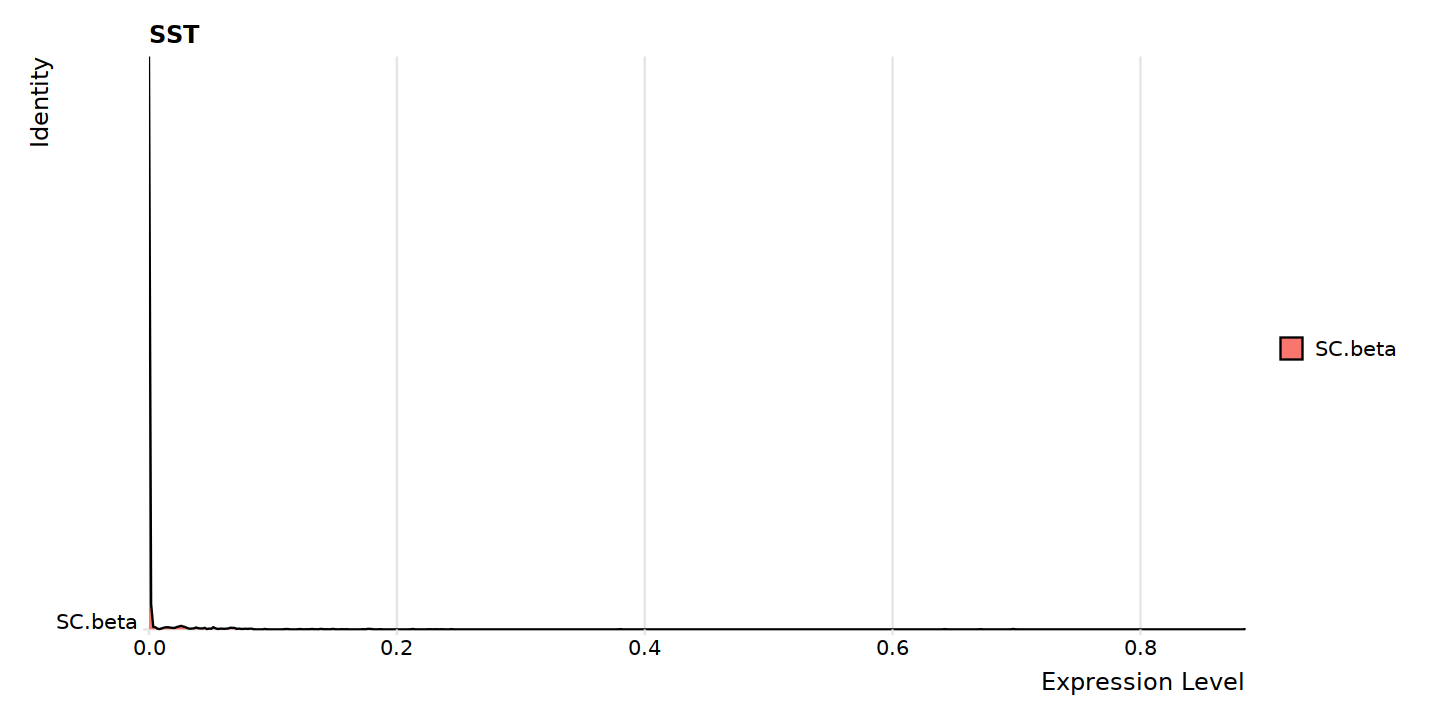

In [25]:
# Do a quick check to see the slots for the metacell object for data slot
RidgePlot(get(NAME, seurat_obj@misc)$wgcna_metacell_obj, features = "SST", assay="RNA", slot="data", group.by = "cell.type.1", ncol=1)

Picking joint bandwidth of 2.7e-06



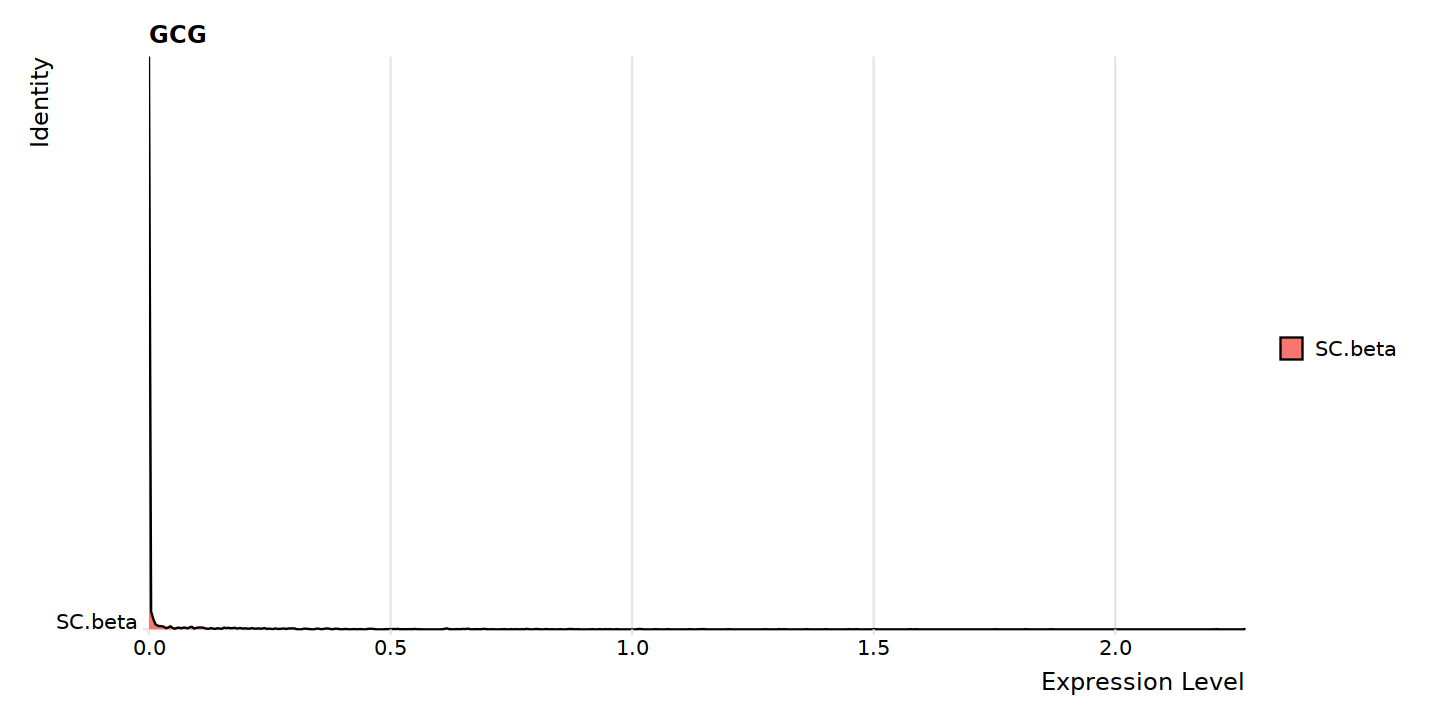

In [26]:
# Do a quick check to see the slots for the metacell object for data slot
RidgePlot(get(NAME, seurat_obj@misc)$wgcna_metacell_obj, features = "GCG", assay="RNA", slot="data", group.by = "cell.type.1", ncol=1)

# Co-expression network analysis

## Transpose the expression matrix
 - This function basically defines the data to run normal WGCNA on
 - Selecting the correct slot here seems crucial to me
 - This will by default use the active assay and the "data" slot: https://github.com/smorabit/hdWGCNA/blob/9ed9084d30891075e69a0d482dd664bcf0e33463/R/getters_and_setters.R
 - I'm excplicitly telling it to use metacells but this is the default

In [27]:
t(data.frame(GetAssayData(object = get(NAME, seurat_obj@misc)$wgcna_metacell_obj, slot = 'data')))[1:5, c("LINC01409", "LINC01128", "SAMD11")]

,LINC01409,LINC01128,SAMD11
SC.beta_1,0.16057486,0.4946416,0.11862672
SC.beta_2,0.39575059,0.1877943,0.14084896
SC.beta_3,0.11939242,0.3276195,0.00000000
SC.beta_4,0.07310301,0.5400908,0.21149093
SC.beta_5,0.07440633,0.3499666,0.03742292


In [28]:
# transpose the matrix, taking care of the
seurat_obj <- SetDatExpr(
    seurat_obj, 
    assay="RNA", 
    use_metacells = TRUE, 
    wgcna_name = NAME, 
    slot="data"
)

In [29]:
# Check what the data matrix looks like
head(get(NAME, seurat_obj@misc)$datExpr)[1:5, c("LINC01409", "LINC01128", "SAMD11")]

,LINC01409,LINC01128,SAMD11
,<dbl>,<dbl>,<dbl>
SC.beta_1,0.16057486,0.4946416,0.11862672
SC.beta_2,0.39575059,0.1877943,0.14084896
SC.beta_3,0.11939242,0.3276195,0.00000000
SC.beta_4,0.07310301,0.5400908,0.21149093
SC.beta_5,0.07440633,0.3499666,0.03742292


In [30]:
# another check of the dimensions before actually doing the network stuff
dim(get(NAME, seurat_obj@misc)$datExpr)

[1]  2580 11003

## Select soft-power threshold
- By default tests a signed network across powers from 1 to 10 by 1 and 12 to 30 by 2

In [31]:
# Test different soft powers:
seurat_obj <- TestSoftPowers(
  seurat_obj,
  use_metacells = TRUE,  # this is the default, I'm just being explicit
  setDatExpr = FALSE  # set this to FALSE since we did this above
)

pickSoftThreshold: will use block size 4066.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4066 of 11003


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 4067 through 8132 of 11003


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 8133 through 11003 of 11003


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k. max.k.
1      1    0.288 11.00          0.952 5590.000  5.60e+03 6040.0
2      2    0.245 -5.01          0.848 2920.000  2.88e+03 3670.0
3      3    0.545 -4.94          0.782 1570.000  1.50e+03 2400.0
4      4    0.805 -4.36          0.902  863.000  7.98e+02 1660.0
5      5    0.927 -3.85          0.975  488.000  4.32e+02 1190.0
6      6    0.947 -3.34          0.985  283.000  2.38e+02  880.0
7      7    0.953 -2.94          0.990  168.000  1.32e+02  669.0
8      8    0.954 -2.65          0.991  103.000  7.46e+01  519.0
9      9    0.947 -2.45          0.987   64.700  4.28e+01  410.0
10    10    0.948 -2.28          0.991   41.800  2.48e+01  329.0
11    12    0.948 -2.04          0.996   18.800  8.51e+00  219.0
12    14    0.941 -1.89          0.994    9.300  3.04e+00  152.0
13    16    0.933 -1.80          0.990    4.980  1.12e+00  108.0
14    18    0.926 -1.74          0.990    2.840  4.20e-01   79.2
15    20    0.933 -1.67  

In [32]:
# plot the results:
options(repr.plot.width=12, repr.plot.height=12)
png(sprintf("%s_softThreshold.png", OUT), widt=600, height=600)
plot_list <- PlotSoftPowers(seurat_obj)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)
dev.off()

  Power  SFT.R.sq     slope truncated.R.sq   mean.k. median.k.    max.k.
1     1 0.2881371 10.968859      0.9517153 5590.6868 5603.3172 6043.7596
2     2 0.2452424 -5.008839      0.8479542 2922.7231 2875.2103 3674.4329
3     3 0.5450047 -4.935994      0.7817115 1568.4551 1495.4946 2403.0160
4     4 0.8050741 -4.358672      0.9016088  863.3839  797.7157 1656.2058
5     5 0.9268446 -3.850557      0.9753876  487.5594  431.7712 1188.4337
6     6 0.9467369 -3.339103      0.9850075  282.5936  237.5245  880.3454
[1] "return"


png 
  2

In [33]:
# get the power table, can also access with head(get(NAME, seurat_obj@misc)$wgcna_powerTable)
power_table <- GetPowerTable(seurat_obj)
head(power_table)

,Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.2881371,10.968859,0.9517153,5590.6868,5603.3172,6043.7596
2,2,0.2452424,-5.008839,0.8479542,2922.7231,2875.2103,3674.4329
3,3,0.5450047,-4.935994,0.7817115,1568.4551,1495.4946,2403.0160
4,4,0.8050741,-4.358672,0.9016088,863.3839,797.7157,1656.2058
5,5,0.9268446,-3.850557,0.9753876,487.5594,431.7712,1188.4337
6,6,0.9467369,-3.339103,0.9850075,282.5936,237.5245,880.3454


In [34]:
power <- power_table$Power[which(power_table$SFT.R.sq > 0.85)[1]]
power

[1] 5

In [35]:
# Save the power table
write.table(power_table, sprintf("%s_powerTable.tsv", OUT), sep="\t")

## Construct co-expression network
- Default is a signed network

In [36]:
# construct co-expression network:
seurat_obj <- ConstructNetwork(
  seurat_obj, 
  soft_power=power,
  use_metacells=TRUE,
  setDatExpr=FALSE,
  tom_name = NAME # name of the topoligical overlap matrix written to disk
)

 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


In [37]:
# plot the dendrogram of the genes in modules
options(repr.plot.width=12, repr.plot.height=12)
png(sprintf("%s_moduleDendrogram.png", OUT), widt=600, height=600)
PlotDendrogram(seurat_obj, main=sprintf('%s Dendrogram', NAME))
dev.off()

png 
  2

In [38]:
# store the TOM object for later
TOM <- GetTOM(seurat_obj)

In [39]:
# Save the TOM object
write.table(TOM, sprintf("%s_TOM.tsv", OUT), sep="\t")

In [40]:
# check the net
names(get(NAME, seurat_obj@misc)$wgcna_net)

[1] "colors"                    "unmergedColors"           
 [3] "multiMEs"                  "goodSamples"              
 [5] "goodGenes"                 "dendrograms"              
 [7] "TOMFiles"                  "blockGenes"               
 [9] "blocks"                    "originCount"              
[11] "networkCalibrationSamples" "individualTOMInfo"        
[13] "consensusTOMInfo"          "consensusQuantile"

In [41]:
# how big are the modules?
table(get(NAME, seurat_obj@misc)$wgcna_net$colors)


     blue     brown     green      grey turquoise    yellow 
     1489       210        99      4453      4636       116 

In [42]:
t(data.frame(table(get(NAME, seurat_obj@misc)$wgcna_net$colors)))

Var1,blue,brown,green,grey,turquoise,yellow
Freq,1489,210,99,4453,4636,116


In [43]:
# Another look at params, this time for net contruction
get(NAME, seurat_obj@misc)$wgcna_params

,name,max_shared,mean_shared,median_shared,density,n,cell.type.1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,SC.beta,10,0.1335837,0,0.358972,2580,SC.beta


# Module Eigengenes and Connectivity

## Compute module eigengenes
 - Defaults to using the first PC as the eigengene
 - Adds data to misc
 - Weited step where correlaiton between average expression of a gene with the ME is negative, everything gets flipped? : https://github.com/smorabit/hdWGCNA/blob/9ed9084d30891075e69a0d482dd664bcf0e33463/R/WGCNA_functions.R

In [44]:
# compute all MEs in the full single-cell dataset
seurat_obj <- ModuleEigengenes(seurat_obj, assay=ASSAY, verbose=FALSE)

[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”


[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”


[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”


[1] "brown"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcabrown_”


[1] "green"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreen_”


[1] "yellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcayellow_”


In [45]:
# module eigengenes:
MEs <- GetMEs(seurat_obj, harmonized=FALSE)

In [46]:
# Save the MEs
write.table(MEs, sprintf("%s_MEs.tsv", OUT), sep="\t")

In [47]:
# Don't really know what the loading are yet...
head(get(NAME, seurat_obj@misc)$ME_loadings)

AL627309.5             LINC01409 
                   "" "0.00460450569691753"  "0.0105349260803903" 
               WRAP73                CAMTA1                 VAMP3 
"0.00557390275827624" "0.00917993265210269" "0.00198351365778718"

## Compute module connectivity
- default uses active assay and "data" slot but can pass them into function

In [48]:
# compute eigengene-based connectivity (kME):
seurat_obj <- ModuleConnectivity(
    seurat_obj,
    assay=ASSAY,
    slot="data",
    harmonized=FALSE
)

Warning message in bicor(datExpr, datME, , use = "p"):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


In [49]:
# rename the modules
seurat_obj <- ResetModuleNames(
  seurat_obj,
  new_name = sprintf("%s-M", NAME)
)

In [50]:
# plot genes ranked by kME for each module
options(repr.plot.width=12, repr.plot.height=12)
png(sprintf("%s_topGenesPerModule.png", OUT), widt=1200, height=1200)
p <- PlotKMEs(seurat_obj, ncol=5)
p
dev.off()

[1] "betacells_allgenes_ND_25neighbors-M1"
[1] "betacells_allgenes_ND_25neighbors-M2"
[1] "betacells_allgenes_ND_25neighbors-M3"
[1] "betacells_allgenes_ND_25neighbors-M4"
[1] "betacells_allgenes_ND_25neighbors-M5"
[1] "betacells_allgenes_ND_25neighbors-M1"
[1] "betacells_allgenes_ND_25neighbors-M2"
[1] "betacells_allgenes_ND_25neighbors-M3"
[1] "betacells_allgenes_ND_25neighbors-M4"
[1] "betacells_allgenes_ND_25neighbors-M5"


png 
  2

In [51]:
# get the module assignment table:
modules <- GetModules(seurat_obj)

# show the first 6 columns:
head(modules[,1:6])

,gene_name,module,color,kME_grey,kME_betacells_allgenes_ND_25neighbors-M1,kME_betacells_allgenes_ND_25neighbors-M2
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
AL627309.5,AL627309.5,grey,grey,0.01621312,0.006754910,0.02796405
LINC01409,LINC01409,grey,grey,-0.05604869,0.008689548,-0.03438470
LINC01128,LINC01128,betacells_allgenes_ND_25neighbors-M1,turquoise,0.12696136,-0.038470429,0.03889360
SAMD11,SAMD11,betacells_allgenes_ND_25neighbors-M1,turquoise,0.13351788,-0.031510842,0.04991408
NOC2L,NOC2L,betacells_allgenes_ND_25neighbors-M1,turquoise,0.07246652,-0.016091112,0.01092801
AGRN,AGRN,betacells_allgenes_ND_25neighbors-M1,turquoise,0.11104950,-0.056400150,-0.01118485


In [52]:
# Save the module assignment table
write.table(modules, sprintf("%s_modules.tsv", OUT), sep="\t")

In [53]:
# Save the fully processed Seurat object to be used in all the other notebooks
saveRDS(seurat_obj, file=sprintf('%s_hdWGCNA.rds', OUT))

---

# Scratch